# Milestone 4 - Additional Algorithm: CatBoost

This notebook corresponds to the fourth and final stage of the Machine Learning final project, as part of the Copernicus Master in Digital Earth, in the Data Science track at University of South Brittany, Vannes, France by Candela Sol PELLIZA & Rajeswari PARASA.

In this milestone we present a new algorithm , CatBoost, to address the same properties' price prediction that we were working with in the previous milestones.


## 1. Presenting the new algorithm: CatBoost

### 1.1. Literal Description

For this final step of the project we introduce the CatBoost algorithm as a promising technique for predicting house prices. 

CatBoost (an acronym derived from "Categorical Boosting") is a gradient boost decision trees algorithm, which has been specifically designed to effectively handle categorical variables, through a technique called "ordered boosting".

A gradient-boosted trees algorithm means mainly three things: 

**Boosting:** Attempts to predict a target accurately by building a sequence of weak and simple models, improving on each model based on the error comitted on the previous one.

**Trees:** Uses binary decision trees as base predictors

**Gradient:** The improvements between one and the next model are calculated using the gradient descent method.

However, while CatBoost shares these bases with other well-known algorithms, such as XGBoost or LighGBM, it differs from those models by two main factors:

**Ordered Boosting:** While some other similar algorithms have the ability to handle categrical variables, they do it generally through a technique called Target Statistics (or variations of it), which has been demostrated to have a prediction shift due to target leakage. CatBoost presents an alternative that addresses this issue by means of "ordered boosting". This technique relies on the ordering principle, introducing a random permutation of the training samples at the different steps of gardient boosting (Prokhorenkova et al., 2017).

**Tree Symmetry:** Contrary to some other algorithms, in CatBoost trees are split consistently (using the same condition) across all nodes at the same depth of the tree (Wong, 2022). 

### 1.2. Why are we choosing CatBoost?
For the final model selection, we revisited our exploratory data analysis based on the following **key** observation with respect to the categorical variables:

We noticed that, none of our previous models, featured any of the categorical (i.e. one-hot-encoded (OHE) variables) as features of high importance. In literature, it is well established that the neighborhood of a property has a high influence on the price of the property. So we expected at least one of the neighborhood (encoded) variables to show up in our models as an important feature. 

As a quick recap, OHE transforms each category inside a variable into a new individual variable, where the rows labelled with that category have a value of 1 and the rest 0. While this is one of the most extended techniques for dealing with categorical variables, it presents the issue of highly increasing the amount of variables, potentially converting highly significant variables into multiple low-importance ones. 

We applied Kruskal Wallis H Test to quickly check whether there was some form of relationship between categorical variables with respect to the sale price. Briefly, Kruskal Wallis H-Test allows us to check if there is a statistically significant difference between groups or categories, say, the different neighborhoods in our data, with respect to a numeric variable or dependent variable [(DATATab, 2023)](https://datatab.net/tutorial/kruskal-wallis-test), here, Sale Price. The p-value is of interest in this test. If p-value is less than the significant level (here 0.01) then we can assume that the respective groups differ with respect to Sale Price. The following are the results* of the test of some of the categorical variables with the lowest p-values: 

| **Variable**       | Statistic       | **P-value**    |
| -------------- | ----------------------- | ----------- |
| Neighborhood   | 868.5     | 6.7e-168   |
| GarageType     | 532.7   | 7.6e-112   |
| MSSubClass     | 531.5       | 1.9e-104 |
| Foundation     | 488.7      | 2.2e-103  |
| MasVnrType     | 281.9     | 8.8e-60   |
| MSZoning       | 270.1       | 3.1e-57  |
| Exterior1st    | 304.0      | 1.7e-56   |
| Exterior2nd    | 284.2       | 1.0e-51  |
| HouseStyle     | 185.4      | 1.4e-36  |
| SaleCondition  | 168.3      | 1.7e-34  |

***Table***: *Test results for Kruskal-Wallis H-test for categorical variables w.r.t. Sale Price*

*Results truncated for brevity - refer Appendix for full results

We can see that the p-values are very low for all the variables, with Neighborhood having the lowest p-value. We concluded from this exercise that at least some of the high-importance categorical variables were converted into multiple independent variables with really low importance in the final models. This analysis led us to think that CatBoost can present an efficient alternative to handle this issue, expecting an improvement in results. After the introduction to CatBoost algorithm in the previous section, we can affirm that one of its main highlights is the efficient categorical variables handling, which has been shown to outperform some other similar algorithms (Prokhorenkova et al., 2017). This characteristic is the main reason that led us to choose CatBoost as our 4th Machine Learnig model.

### 1.3. Python Implementation
The CatBoost algorithm is implemented in python using the library provided by the official [CatBoost project](https://catboost.ai/en/docs/concepts/parameter-tuning). The CatBoost library can be installed by uncommenting the code line below:

In [4]:
#%pip install catboost

### 1.4. Hyperparameters

According to the CatBoostRgressor documentation, the main hyperparameters of the model are:

**Number of trees:**  maximum number of trees that the model can contain. (`iterations`)

**Learning rate:** Steps size in gradient descent. (`learning_rate`)

**Tree Depth:** Maximum depth of trees. (`depth`)

**L2 regularization:** Coefficient of the regularzation term of the cost function. (`l2_leaf_reg`)

**Random strength:** Amount of randomness for scoring splits when the tree structure is selected. (`random_strength`)

## 2. Data Loading and Preprocessing

To start the project, we will upload the original raw dataset. Different from the previous notebooks, in which we used directly the preprocessed and split training and test datasets, here the preprocessing step will be carried on again. This is because, as it was said before, one of the main advantadges of CatBoost algorithm is the fact that it can deal with categorical variables. Therefore, we need to re-apply the data processing steps to our dataset, leaving out the encoding of categorical variables. 

Moreover, some other modifications to the porcessing steps are applied according to the feedback of Milestone 2, such as data KFold stratification, which are discussed in detail in the corresponding section.

### 2.1. Loading Libraries & Importing Original Dataset

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import warnings
import catboost

In [2]:
#Setting pandas to show all the columns
pd.set_option('display.max_columns', None)

In [3]:
#Importing  and visualizing the dataset
data = pd.read_csv('OpenData/Ames.csv')
data.head()

Order        PID  area   price  MS.SubClass MS.Zoning  Lot.Frontage  \
0      1  526301100  1656  215000           20        RL         141.0   
1      2  526350040   896  105000           20        RH          80.0   
2      3  526351010  1329  172000           20        RL          81.0   
3      4  526353030  2110  244000           20        RL          93.0   
4      5  527105010  1629  189900           60        RL          74.0   

   Lot.Area Street Alley Lot.Shape Land.Contour Utilities Lot.Config  \
0     31770   Pave   NaN       IR1          Lvl    AllPub     Corner   
1     11622   Pave   NaN       Reg          Lvl    AllPub     Inside   
2     14267   Pave   NaN       IR1          Lvl    AllPub     Corner   
3     11160   Pave   NaN       Reg          Lvl    AllPub     Corner   
4     13830   Pave   NaN       IR1          Lvl    AllPub     Inside   

  Land.Slope Neighborhood Condition.1 Condition.2 Bldg.Type House.Style  \
0        Gtl        NAmes        Norm        Norm      1Fam      1Story   
1        Gtl        NAmes       Feedr        Norm      1Fam      1Story   
2        Gtl        NAmes        Norm        Norm      1Fam      1Story   
3        Gtl        NAmes        Norm        Norm      1Fam      1Story   
4        Gtl      Gilbert        Norm        Norm      1Fam      2Story   

   Overall.Qual  Overall.Cond  Year.Built  Year.Remod.Add Roof.Style  \
0             6             5        1960            1960        Hip   
1             5             6        1961            1961      Gable   
2             6             6        1958            1958        Hip   
3             7             5        1968            1968        Hip   
4             5             5        1997            1998      Gable   

  Roof.Matl Exterior.1st Exterior.2nd Mas.Vnr.Type  Mas.Vnr.Area Exter.Qual  \
0   CompShg      BrkFace      Plywood        Stone         112.0         TA   
1   CompShg      VinylSd      VinylSd         None           0.0         TA   
2   CompShg      Wd Sdng      Wd Sdng      BrkFace         108.0         TA   
3   CompShg      BrkFace      BrkFace         None           0.0         Gd   
4   CompShg      VinylSd      VinylSd         None           0.0         TA   

  Exter.Cond Foundation Bsmt.Qual Bsmt.Cond Bsmt.Exposure BsmtFin.Type.1  \
0         TA     CBlock        TA        Gd            Gd            BLQ   
1         TA     CBlock        TA        TA            No            Rec   
2         TA     CBlock        TA        TA            No            ALQ   
3         TA     CBlock        TA        TA            No            ALQ   
4         TA      PConc        Gd        TA            No            GLQ   

   BsmtFin.SF.1 BsmtFin.Type.2  BsmtFin.SF.2  Bsmt.Unf.SF  Total.Bsmt.SF  \
0         639.0            Unf           0.0        441.0         1080.0   
1         468.0            LwQ         144.0        270.0          882.0   
2         923.0            Unf           0.0        406.0         1329.0   
3        1065.0            Unf           0.0       1045.0         2110.0   
4         791.0            Unf           0.0        137.0          928.0   

  Heating Heating.QC Central.Air Electrical  X1st.Flr.SF  X2nd.Flr.SF  \
0    GasA         Fa           Y      SBrkr         1656            0   
1    GasA         TA           Y      SBrkr          896            0   
2    GasA         TA           Y      SBrkr         1329            0   
3    GasA         Ex           Y      SBrkr         2110            0   
4    GasA         Gd           Y      SBrkr          928          701   

   Low.Qual.Fin.SF  Bsmt.Full.Bath  Bsmt.Half.Bath  Full.Bath  Half.Bath  \
0                0             1.0             0.0          1          0   
1                0             0.0             0.0          1          0   
2                0             0.0             0.0          1          1   
3                0             1.0             0.0          2          1   
4                0             0.

### 2.2. First Preprocessing Steps

#### 2.2.a. Renaming variables
In order to get a better and uniform handling of the variables, the columns of the original dataset are renamed, adopting the Pascal case convention (capitalizing the first letter of every word, including the first one). The abreviations for long words are kept the same as in the original dataset.

In [4]:
#Create a dictionary with the old and new variable's names
RenameMapping = {
    'area': 'BldgArea',
    'price': 'SoldPrice',
    'MS.SubClass': 'MSSubClass',
    'MS.Zoning': 'MSZoning',
    'Lot.Frontage': 'LotFrontage',
    'Lot.Area': 'LotArea',
    'Lot.Shape': 'LotShape',
    'Land.Contour': 'LandContour',
    'Lot.Config': 'LotConfig',
    'Land.Slope': 'LandSlope',
    'Condition.1': 'Condition1',
    'Condition.2': 'Condition2',
    'Bldg.Type': 'BldgType',
    'House.Style': 'HouseStyle',
    'Overall.Qual': 'OverallQual',
    'Overall.Cond': 'OverallCond',
    'Year.Built': 'YearBuilt',
    'Year.Remod.Add': 'YearRemodAdd',
    'Roof.Style': 'RoofStyle',
    'Roof.Matl': 'RoofMatl',
    'Exterior.1st': 'Exterior1st',
    'Exterior.2nd': 'Exterior2nd',
    'Mas.Vnr.Type': 'MasVnrType',
    'Mas.Vnr.Area': 'MasVnrArea',
    'Exter.Qual': 'ExterQual',
    'Exter.Cond': 'ExterCond',
    'Bsmt.Qual': 'BsmtQual',
    'Bsmt.Cond': 'BsmtCond',
    'Bsmt.Exposure': 'BsmtExposure',
    'BsmtFin.Type.1': 'BsmtFinType1',
    'BsmtFin.SF.1': 'BsmtFinSF1',
    'BsmtFin.Type.2': 'BsmtFinType2',
    'BsmtFin.SF.2': 'BsmtFinSF2',
    'Bsmt.Unf.SF': 'BsmtUnfSF',
    'Total.Bsmt.SF': 'TotalBsmtSF',
    'Heating.QC': 'HeatingQual',
    'Central.Air': 'CentralAir',
    '1st.Flr.SF': '1stFlrSF',
    '2nd.Flr.SF': '2ndFlrSF',
    'Low.Qual.Fin.SF': 'LowQualFinSF',
    'Bsmt.Full.Bath': 'BsmtFullBath',
    'Bsmt.Half.Bath': 'BsmtHalfBath',
    'Full.Bath': 'FullBath',
    'Half.Bath': 'HalfBath',
    'Kitchen.Qual': 'KitchenQual',
    'TotRms.AbvGrd': 'TotRmsAbvGrd',
    'Fireplaces': 'Fireplaces',
    'Fireplace.Qu': 'FireplaceQu',
    'Garage.Type': 'GarageType',
    'Garage.Yr.Blt': 'GarageYrBlt',
    'Garage.Finish': 'GarageFinish',
    'Garage.Cars': 'GarageCars',
    'Garage.Area': 'GarageArea',
    'Garage.Qual': 'GarageQual',
    'Garage.Cond': 'GarageCond',
    'Paved.Drive': 'PavedDrive',
    'Wood.Deck.SF': 'WoodDeckSF',
    'Open.Porch.SF': 'OpenPorchSF',
    'Enclosed.Porch': 'EnclosedPorchSF',
    '3Ssn.Porch': '3SsnPorchSF',
    'Screen.Porch': 'ScreenPorchSF',
    'Pool.Area': 'PoolArea',
    'Pool.QC': 'PoolQual',
    'Misc.Feature': 'MiscFeature',
    'Misc.Val': 'MiscVal',
    'Mo.Sold': 'MoSold',
    'Yr.Sold': 'YrSold',
    'Sale.Type': 'SaleType',
    'Sale.Condition': 'SaleCondition',
    'X1st.Flr.SF': 'X1FloorSF',
    'X2nd.Flr.SF': 'X2FloorSF',
    'X3Ssn.Porch': '3SsnPorchSF',
    'Kitchen.AbvGr': 'KitchenAbvGr',
    'Bedroom.AbvGr': 'BedroomAbvGr',
    }

#Applying the name change
data.rename(columns=RenameMapping, inplace=True)

Moreover, we will also remove the "order" column, considering that it is just an index column withou any significative meaning, and the dataset has a meaningful identificator given by the column "PID"

In [5]:
#Dropping 'Order' column
data = data.drop('Order', axis=1)

#### 2.2.b. Encoding Ordinal and Binary Variables
While CatBoost algorithm can weffectively handle categorical variables, for the case of ordinal and binary varibles we decided to rely on a controlled process. For these cases, we will follow the same process explained in Milestone 1 for converting ordinal and binary "string" variables into numerical ones. For more detailed explanations on each case, refer to Milestone 1 notebook.

In [6]:
# Lists of variables by type
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQual', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQual', 'Fence', 'PavedDrive' ]
nominal = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
binary = ['Street', 'CentralAir']
other = ['Alley']

##### 2.2.b.1. Encoding Ordinal Variables

In [7]:
# Mapping dictionary
variable_mappings = {
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 6, 'Gd': 5, 'Ta': 4, 'Fa': 3, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 6, 'Gd': 5, 'Ta': 4, 'Fa': 3, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'Lwq': 2, 'Unf': 1, 'Na': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'Lwq': 2, 'Unf': 1, 'Na': 0},
    'HeatingQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'PoolQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Na': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2}
}

# List of columns to map
columns_to_map = variable_mappings.keys()

def apply_mappings(data):
    for column in columns_to_map:
        data[column] = data[column].map(variable_mappings[column])

# Applying changes to dataset
apply_mappings(data)

# Iterate through the columns in the 'ordinal' list and encode NA values as 0
for column in ordinal:
    data[column].fillna(0, inplace=True)

##### 2.2.b.2. Encoding Binary Variables

In [8]:
#Convert binary variables into numerical
Street = {'Grvl': 0, 'Pave': 1}
CentralAir = {'N': 0, 'Y': 1}

#Applying changes to ataset
data['Street'] = data['Street'].map(Street)
data['CentralAir'] = data['CentralAir'].map(CentralAir)

For the case of the 'Alley' variable, we also follow what was already discussed in Milestone 1. Given that the variable has 3 categories, 2 indicating different types of alley material (which a small amunt of positive rows each one), and the third type indicating that the house doesn't have an alley, the variable is also coverted to a binary variable, indicating the existence or not of an alley.

In [9]:
#Encode
Alley = {'Grvl': 1, 'Pave': 1, 'NA': 0}

#Applying changes to dataset
data['Alley'] = data['Alley'].map(Alley)

#Encode NA values as 0
data['Alley'].fillna(0, inplace=True)

### 2.3. Data Split into Train and Test

Following the generally agreed good practices on Machine Learning models treatment, the remaining preprocessing steps, related to NA values handling, are performed after the data splitting is done. This workflow assures that there is no data leakage occuring between the training and test sets in the case that the values of existing rows are used to fill missing values (ex: if filling NA with column mean).

The data splitting is done following the same workflow already explained in Milestone 2, in which we demonstrated the importance of permorfiming a neighborhood-based splitting, due to an unbalanced spatial distribution. We also apply the same rows dropping based on the small number of samples in certain neighbirhoods. For more details on this regard, please refer to the mentioned notebook.

In [10]:
# Drop the lines for Landmrk and GrnHill neighborhoods
neighb_todrop = ['Landmrk', 'GrnHill']
data = data[~data['Neighborhood'].isin(neighb_todrop)]

# Divide data into train and test with stratified split
data_train, data_test= train_test_split(data, test_size=0.2, random_state=33, stratify=data['Neighborhood'])

### 2.4. Handling NA Values
The workflow for NA values handling also follows the same process already analyzed, explained and established for each variable in Milestone 1. for more details, please refer to the mentioned notebook.

In [11]:
#Filling NAs on training
data_train['MiscFeature'].fillna('None', inplace=True)
data_train['GarageType'].fillna('None', inplace=True)

#Filling NAs on test
data_test['MiscFeature'].fillna('None', inplace=True)
data_test['GarageType'].fillna('None', inplace=True)

In [12]:
columns_to_check = ['MasVnrType' , 'BsmtHalfBath', 'BsmtFullBath', 'GarageCars', 'Electrical', 'GarageArea']

#  Drop rows with NaN values in specific columns in training
data_train.dropna(subset=columns_to_check, inplace=True)

# Drop rows with NaN values in specific columns in test
data_test.dropna(subset=columns_to_check, inplace=True)

In [13]:
## LotFrontage VARIABLE

#Fill Na values with column mean - training
mean_LotFrontage_train = data_train['LotFrontage'].mean()
data_train['LotFrontage'].fillna(mean_LotFrontage_train, inplace=True)

#Fill Na values with column mean - test
mean_LotFrontage_test = data_test['LotFrontage'].mean()
data_test['LotFrontage'].fillna(mean_LotFrontage_test, inplace=True)

In [14]:
## GarageYrBlt VARIABLE

#Filling GarageYrBlt NA values with YearBuilt in training
data_train['GarageYrBlt'].fillna(data_train['YearBuilt'], inplace=True)

#Filling GarageYrBlt NA values with YearBuilt in test
data_test['GarageYrBlt'].fillna(data_test['YearBuilt'], inplace=True)

In [15]:
# drop PID 
data_train.drop('PID', axis=1, inplace=True)
data_test.drop('PID', axis=1, inplace=True)

Finally, we check that there is not any NA value in both train and test datasets and we visualize how the datasets looks like after preprocessing.

In [16]:
#Check NAs in test
data_test.isna().any().any()

False

In [17]:
#Check NAs in test
data_test.isna().any().any()

False

In [18]:
# Previsualize train dataset
data_train.head()

BldgArea  SoldPrice  MSSubClass MSZoning  LotFrontage  LotArea  Street  \
174       1605     107400          50       RM    60.000000     5790       1   
1765      2582     322500          60       RL    74.000000    11002       1   
2891      2519     335000          60       RL    42.000000    26178       1   
125       1728      84900          90       RL    98.000000    13260       1   
1234      1098     135000          20       RL    69.099331     7390       1   

      Alley  LotShape LandContour  Utilities LotConfig  LandSlope  \
174     0.0         4         Lvl          4    Corner          1   
1765    0.0         3         Lvl          4    Inside          1   
2891    0.0         3         Lvl          4    Inside          2   
125     0.0         3         Lvl          4    Inside          1   
1234    0.0         3         Lvl          4    Inside          1   

     Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
174       OldTown       Norm       Norm     1Fam     2Story            3   
1765      NoRidge       Norm       Norm     1Fam     2Story            8   
2891       Timber       Norm       Norm     1Fam     2Story            7   
125         NAmes       Norm       Norm   Duplex     1Story            5   
1234        NAmes       Norm       Norm     1Fam     1Story            5   

      OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
174             6       1915          1950   Gambrel  CompShg     VinylSd   
1765            5       1998          1999     Gable  CompShg     VinylSd   
2891            5       1989          1990       Hip  CompShg     MetalSd   
125             6       1962          2001       Hip  CompShg     HdBoard   
1234            7       1955          1955       Hip  CompShg     Wd Sdng   

     Exterior2nd MasVnrType  MasVnrArea  ExterQual  ExterCond Foundation  \
174      VinylSd       None         0.0        4.0        4.0     CBlock   
1765     VinylSd       None         0.0        4.0        0.0      PConc   
2891     MetalSd    BrkFace       293.0        4.0        0.0      PConc   
125      HdBoard    BrkFace       144.0        0.0        0.0     CBlock   
1234     Wd Sdng    BrkFace       151.0        0.0        0.0     CBlock   

      BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
174        3.0       0.0           0.0           1.0         0.0   
1765       5.0       0.0           0.0           6.0      1048.0   
2891       5.0       0.0           4.0           6.0       965.0   
125        0.0       0.0           0.0           4.0      1500.0   
1234       0.0       0.0           0.0           5.0       902.0   

      BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  HeatingQual  \
174            1.0         0.0      840.0        840.0    GasA            4   
1765           1.0         0.0      341.0       1389.0    GasA            5   
2891           1.0         0.0      245.0       1210.0    GasA            5   
125            1.0         0.0      228.0       1728.0    GasA            3   
1234           1.0         0.0      196.0       1098.0    GasA            3   

      CentralAir Electrical  X1FloorSF  X2FloorSF  LowQualFinSF  BsmtFullBath  \
174            0      SBrkr        840        765             0           0.0   
1765           1      SBrkr       1411       1171             0           1.0   
2891           1      SBrkr       1238       1281             0           1.0   
125            1      SBrkr       1728          0             0           2.0   
1234           1      SBrkr       1098          0             0           1.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
174            0.0         2         0             3             2   
1765           0.0         2         1             4             1   
2891           0.0         2         1             4             1   
125            0.0         2         0             6             2   
1234        

In [19]:
# Previsualize test dataset
data_test.head()

BldgArea  SoldPrice  MSSubClass MSZoning  LotFrontage  LotArea  Street  \
1604       816     130500          20       RL    60.000000     6600       1   
2510      1524     166000         160       FV    69.392857     2998       1   
430       2020     402861          20       RL    94.000000    12220       1   
2900      1960     320000          20       RL    95.000000    13618       1   
665        725      78500          30       RL    60.000000    10800       1   

      Alley  LotShape LandContour  Utilities LotConfig  LandSlope  \
1604    0.0         4         Lvl          4    Inside          1   
2510    0.0         4         Lvl          4    Inside          1   
430     0.0         4         Lvl          4    Inside          1   
2900    0.0         4         Lvl          4    Corner          1   
665     1.0         4         Lvl          4    Corner          1   

     Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
1604      Mitchel       Norm       Norm     1Fam     1Story            5   
2510      Somerst       Norm       Norm   TwnhsE     2Story            6   
430       NridgHt       Norm       Norm     1Fam     1Story           10   
2900       Timber       Norm       Norm     1Fam     1Story            8   
665       OldTown       Norm       Norm     1Fam     1Story            3   

      OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
1604            9       1982          2008     Gable  CompShg     VinylSd   
2510            5       2000          2000     Gable  CompShg     MetalSd   
430             5       2009          2009       Hip  CompShg     CemntBd   
2900            5       2005          2006     Gable  CompShg     VinylSd   
665             5       1890          1998     Gable  CompShg     VinylSd   

     Exterior2nd MasVnrType  MasVnrArea  ExterQual  ExterCond Foundation  \
1604     VinylSd       None         0.0        4.0        4.0     CBlock   
2510     MetalSd    BrkFace       513.0        4.0        0.0      PConc   
430      CmentBd    BrkFace       305.0        5.0        0.0     CBlock   
2900     VinylSd      Stone       198.0        4.0        0.0      PConc   
665      VinylSd       None         0.0        0.0        0.0     BrkTil   

      BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
1604       0.0       0.0           0.0           5.0       641.0   
2510       5.0       0.0           0.0           6.0       353.0   
430        6.0       0.0           0.0           6.0      1436.0   
2900       6.0       5.0           0.0           6.0      1350.0   
665        0.0       0.0           0.0           1.0         0.0   

      BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  HeatingQual  \
1604           1.0         0.0      175.0        816.0    GasA            5   
2510           1.0         0.0      403.0        756.0    GasA            5   
430            1.0         0.0      570.0       2006.0    GasA            5   
2900           1.0         0.0      378.0       1728.0    GasA            5   
665            1.0         0.0      630.0        630.0    GasA            3   

      CentralAir Electrical  X1FloorSF  X2FloorSF  LowQualFinSF  BsmtFullBath  \
1604           1      SBrkr        816          0             0           0.0   
2510           1      SBrkr        768        756             0           0.0   
430            1      SBrkr       2020          0             0           1.0   
2900           1      SBrkr       1960          0             0           1.0   
665            1      FuseA        725          0             0           0.0   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
1604           1.0         1         0             3             1   
2510           0.0         2         1             2             1   
430            0.0         2         1             3             1   
2900           0.0         2         0             3             1   
665         

## 3. Tuning CatBoost Model
Once that the data is preprocessed and divided into test and training sets, we will proceed with the application of the algorithm. In this case, as our problem is a regression problem, we will use the CatBoostRegressor model from the CatBoost library.

### 3.1. Installing and Importing Libraries

Run the line below to install optuna library (for hyperparameters tuning)

In [24]:
# %pip install optuna

In [20]:
# import utilities
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, make_scorer

# for bayesian tuning
import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric

### 3.2. Hyperparameters tuning


As it was explained in the introduction, the CatBoost algorithm includes a set of hyperparameters that have a big impact on the model: `iterations`, `learning_rate`, `depth`, `l2_leaf_reg` and `random_strength` [(AWS, 2023)](https://docs.aws.amazon.com/sagemaker/latest/dg/catboost-tuning.html). 
All these hyperparameters will be tuned, except for the learning rate, because the CatBoost library provides an automatic detection of the best value according to the model configuration.


#### 3.2.a. Train and Validation Splits
The first step consists of dividing the train set into training and validation sets, with a proportion of 80% - 20%. The division is again performed stratifying the data by neighborhood for mantaining the spatially-controlled division. We would like to highlight that we only use one validation set for the hyperparameter tuning instead of many *k*-folds as is done in other techniques suchs as in cross-validation. This is because we use a Bayesian optimization approach instead of cross-validation for the hyperparameter tuning, which gives a reasonably good result without requiring several validation sets. We explain the Bayesian optimization later in this section. 

In [21]:
# create train and validation sets for hyperparameter tuning by performing a stratified split on the Neighborhood variable
train_df, val_df= train_test_split(data_train, test_size=0.2, random_state=33, stratify=data_train['Neighborhood'])

#### 3.2.b. Creation of Pool Objects
After this we create the training and validation pools which are the required objects for tuning and training the CatBoost model. 

In [22]:
#cat_names = list(data_train.drop('SoldPrice', axis=1).select_dtypes(include=['object']).columns)
cat_names = nominal

# create a train and validation pools
train_pool = Pool(train_df.drop('SoldPrice', axis=1), label = train_df['SoldPrice'], cat_features = cat_names)
val_pool = Pool(val_df.drop('SoldPrice', axis=1), label = val_df['SoldPrice'], cat_features = cat_names)

We create functions for the custom functions for the metrics we have defined in the previous milestones.

In [43]:
# Function for calculating RMSE
def rmse(y_test, y_pred):
    """
    This function calculates the RMSE between the predicted and the actual values
    -------------------------------------------
    Parameters:
    y_test (array): Array of actual values
    y_pred (array): Array of predicted values

    Returns:
    float: RMSE value
    """
    return np.sqrt(mean_squared_error(y_test, y_pred))
# Define a custom scorer for RMSE
rmse_scorer = make_scorer(rmse)

def rmsle(y_test, y_pred):
    """
    This function calculates the RMSLE between the predicted and the actual values
    -------------------------------------------
    Parameters:
    y_test (array): Array of actual values
    y_pred (array): Array of predicted values
    
    Returns:
    float: RMSLE value
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

# Define a custom scorer for RMSLE
rmsle_scorer = make_scorer(rmsle)

# Define a custom scorer for R2
r2_scorer = make_scorer(r2_score)

#### 3.2.c. Tuning with Optuna
For tuning the hyperparameters we will use a Bayesian optimization algorithm supported by the Optuna library. We attempted Grid-Search (results in Appendix) for hyperparameter tuning but it took the program >2 hours to complete one entire run. Bayesian optimization is much more efficient than other methods such as randomized and grid-based searches as they do not keep track of past results while searching for the best hyperparameters [(Atygayev, 2021)](https://github.com/catboost/catboost/blob/master/catboost/tutorials/hyperparameters_tuning/hyperparameters_tuning_using_optuna_and_hyperopt.ipynb). Whereas, Bayesian optimisation uses past results to minimize/maximize the objective function (*Ibid*.). [Optuna](https://optuna.org/) automatically searches the optimal set of hyperparameter values by trial and error, basing the guess on the historical record of tried values to determine the following trial. Hence, some form of convergence can be expected. In terms of computational time considerations, it is a recommended approach for boosting algorithms. 

For the tuning purpose, a range of minimum and maximum possible values is passed for each hyperparameter. These ranges are defined based on the literature and recommendations by the official CatBoost library ([AWS, 2023](https://docs.aws.amazon.com/sagemaker/latest/dg/catboost-tuning.html); [Filho, 2023](https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/); [Catboost, n.d.](https://catboost.ai/en/docs/references/training-parameters/common)).

In [175]:
%%time
import optuna
from optuna.samplers import TPESampler

# define objective function the output of which will be minimized by Optuna
def objective(trial):
    params = {
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 10),
        'iterations': trial.suggest_int('iterations', 200, 1400),    
        }

    # define the model with the given parameters, make predictions
    model = catboost.CatBoostRegressor(**params, random_seed=33)
    model.fit(train_pool, verbose=0)
    y_pred = model.predict(val_pool)

    # define the loss function and return the loss value on which to optimize
    loss = rmsle(val_df['SoldPrice'], y_pred)
    return loss

# fix seed for reproducibility
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2023-11-22 05:08:29,970] A new study created in memory with name: no-name-92241a84-f5b7-4c31-8297-e34d316732f4


[I 2023-11-22 05:09:11,095] Trial 0 finished with value: 0.12344077376678107 and parameters: {'random_strength': 6.964691855978616, 'depth': 6, 'l2_leaf_reg': 3.814811628513625, 'iterations': 862}. Best is trial 0 with value: 0.12344077376678107.
[I 2023-11-22 05:09:57,545] Trial 1 finished with value: 0.12606148625437832 and parameters: {'random_strength': 7.1946896978556305, 'depth': 6, 'l2_leaf_reg': 9.846113587076925, 'iterations': 1022}. Best is trial 0 with value: 0.12344077376678107.
[I 2023-11-22 05:10:50,416] Trial 2 finished with value: 0.12391869113085249 and parameters: {'random_strength': 4.809319014843609, 'depth': 6, 'l2_leaf_reg': 4.745424129206955, 'iterations': 1075}. Best is trial 0 with value: 0.12344077376678107.
[I 2023-11-22 05:11:24,221] Trial 3 finished with value: 0.1278864683685294 and parameters: {'random_strength': 4.385722446796244, 'depth': 4, 'l2_leaf_reg': 5.184354042643451, 'iterations': 1086}. Best is trial 0 with value: 0.12344077376678107.
[I 2023-1

CPU times: total: 35min 30s
Wall time: 26min 11s


After the optimization process, we get the dictionary with the best found values for each hyperparameter.

In [176]:
# best iteration's RMSLE and corresponding parameters
study.best_value, study.best_params

(0.11735312906453986,
 {'random_strength': 1.1013286984412884,
  'depth': 8,
  'l2_leaf_reg': 2.2361811750892073,
  'iterations': 1383})

## 4. Evaluating Test Performance

We will now train the model using the obtained values for the hyperparameters. For this we will create a new pool with the train and validation sets together for training the final model.

### 4.2. Creating Training and Test Pools

In [32]:
# create a train pool on the entire training set (including the validation set)
train_pool_whole = Pool(data_train.drop('SoldPrice', axis=1), 
                  label = data_train['SoldPrice'],
                  cat_features = cat_names)

# create a test pool
test_pool = Pool(data_test.drop('SoldPrice', axis=1), 
                  label = data_test['SoldPrice'],
                  cat_features = cat_names)

In [38]:
# function to plot actual and predicted values along with x=y line
def plot_Yt_Yp(y_test, y_pred, set_limit=None):
    """
    Plots the actual vs predicted values
    ------------------------------------
    Parameters:
    y_test: actual values
    y_pred: predicted values

    Returns:
    None
    """
    plt.scatter(y_test, y_pred, alpha=0.3, label= 'Property Sold')
    plt.xlabel('Actual Sold Price')
    plt.ylabel('Predicted Sold Price')
    plt.title('Actual vs Predicted Sold Price')
    # Set axis limits if set_limit parameter is provided
    if set_limit:
        plt.axis(set_limit)
    #plot x=y line
    plt.plot(np.linspace(np.min(y_test), np.max(y_test), 1000), np.linspace(np.min(y_test), np.max(y_test) , 1000), color='red', label= 'x=y line')
    plt.legend()
    plt.show()

### 4.3. Testing the Base Model

As a first step we will train and test the base model, using all the default values to analyze the base performance.

In [168]:
# Train, fit and predict base model

model1 = catboost.CatBoostRegressor(random_seed=33)
model1.fit(train_pool_whole, verbose=0)
y_pred = model1.predict(test_pool)

In [169]:
model1.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

Now we plot the metrics and the graphic of real vs. predicted sold price

RMSLE:  0.10803332617392655
R2 Score:  0.9365221948264288
RMSE:  19845.528588620513


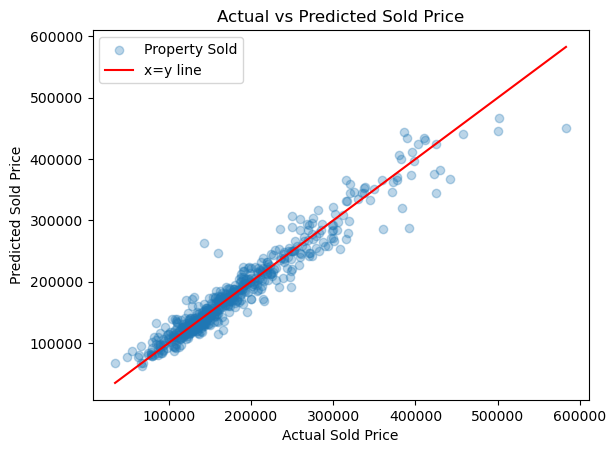

In [170]:
print('RMSLE: ', rmsle(data_test['SoldPrice'], y_pred))
print('R2 Score: ', model1.score(data_test.drop('SoldPrice', axis=1), data_test['SoldPrice']))
print('RMSE: ',rmse(data_test['SoldPrice'], y_pred))
plot_Yt_Yp(data_test['SoldPrice'].values, y_pred)

### 4.4. Testing the Tuned Model
Now we will test the model with the tuned hyperparameters values.

It is important to remark that CatBoostRegressor includes a long list of parameters (97 in total), from which mostly are optional for specific requirements. From this list, we will explain the function of some of the most important ones, and why we are selecting or leaving as default their values:


**iterations**=1390 # Hyperparameter tuned

**learning_rate**=None # Not tuned because the optimal value is found automatically

**depth**=10 # Hyperparameter tuned

**l2_leaf_reg**=7.3 # Hyperparameter tuned

**rsm**=1 (default) # The 100% of the features are used at each split selection

**loss_function**='RMSE' (default) # Uses RMSE as the metric for loss function

**nan_mode**=None (default) # value to replace NaN values. Not used because we filled all missing values before training

**leaf_estimation_method**=Gradient (default) Method used to calculate the values in leaves

**random_seed**=33 # Allows reproducibility

**use_best_model**=False (default) # If set to true the fianl model contains only the optimal value of trees based on validation. This is done previously.

**best_model_min_trees**=None (default) # Not minimum number of trees is given. The number of trees used is the found as optimal

**has_time**=False (default) # Used if the data has timestamp

**allow_const_label**=False (default) # used for training models with datasets that have equal label values for all objects

**one_hot_max_size**=2 (default) # the categorical variables with lees than this number of different values are encoded using one-hot encoding. In our case all the categorical variables have more than 2 different values.

**random_strength**=0.104 # hyperparameter tuned

**ignored_features**=None (default) # Used if some feature needs to be ignored for training

**eval_metric**=None (default) #Used in case automatic overfitting detection is enabled

**bootstrap_type**=SVM (default) # Other types such as Bernoulli were explored, giving a worst result

**bagging_temperature**=None (default) # Settings of Bayesian bootstrap. Used by default in regression models

**boosting_type**=Plain (default) # Ordered option only used for small datasets

**subsample**=None (default) # Used for defininf custom sample rate for bagging 

**grow_policy**=SymmetricTree (default) # On each iteration, all leaves from the last tree level are split with the same condition. 

**min_data_in_leaf**=2 (default) # minimum number of training samples in a leaf

**max_leaves**=31 (default) # Can only be specified when using Lossguide growing policy

**score_function**=Cosine (default) score type used to select next split during tree construction


We fit the model with the defined parameters and predict on test pool

In [177]:
model2 = catboost.CatBoostRegressor(depth= 8, l2_leaf_reg= 2.24, random_strength= 1.101, iterations=1383, random_seed=33)
model2.fit(train_pool_whole, verbose=0)
y_pred = model2.predict(test_pool)

In [181]:
model2.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1383,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 2.240000009536743,
 'random_strength': 1.10099995136261,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:

After predicting the values, we plot below, the analysis metrics and the real vs. predicted prices. 

RMSLE:  0.10790670356507337
R2 Score:  0.9375039592530839
RMSE:  19691.462478731464


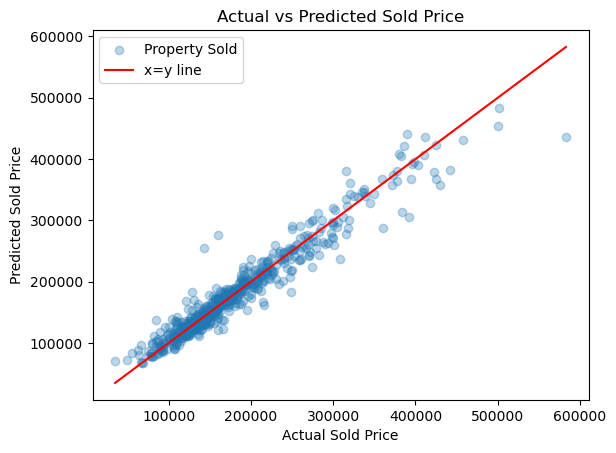

In [178]:
print('RMSLE: ', rmsle(data_test['SoldPrice'], y_pred))
print('R2 Score: ', model2.score(data_test.drop('SoldPrice', axis=1), data_test['SoldPrice']))
print('RMSE: ',rmse(data_test['SoldPrice'], y_pred))
plot_Yt_Yp(data_test['SoldPrice'].values, y_pred)

### 4.5. Comparing the results of CatBoost models - Tuned vs. Not Tuned

Evaluation metrics generated on the test data of the tuned and not tuned models are summarized in the table below:

| **Metric** | **Untuned*** | **Tuned** |
| --- | --- | --- |
| RMSLE | 0.1080| 0.1079|
| R2 Score | 0.9365| 0.9375|
| RMSE | 19845.53| 19691.46|

*Default or automatically calculated by catboost

We observe that the tuned model performs only slightly better than the not tuned one (Delta RMSLE, Delta R2 Score ~ 0, Delta RMSE ~ 150). This is probably due to the fact that the parameters automatically determined by the catboost algorithm based on the data are well suited for training. Further, the default values for the rest of the parameters are well defined. So in our case, the tuning process improved the performance of the model only marginally. However, more experiments can be performed with other parameters such as with the learning rate, which was not tuned in this case, to better understand their influence on our model for determining an enhanced configuration.

Parameters of the tuned and not tuned models are summarized in the table below:

| **Parameter**                   | **Untuned**                             | **Tuned**                                 |
|--------------------------------|------------------------------------------|------------------------------------------|
| nan_mode                       | 'Min'                                    | 'Min'                                    |
| eval_metric                    | 'RMSE'                                   | 'RMSE'                                   |
| **iterations**                 | **1000**                             | **1383**                                     |
| sampling_frequency             | 'PerTree'                                | 'PerTree'                                |
| fold_permutation_block         | 0                                        | 0                                        |
| leaf_estimation_method          | 'Newton'                                 | 'Newton'                                 |
| random_score_type              | 'NormalWithModelSizeDecrease'            | 'NormalWithModelSizeDecrease'            |
| counter_calc_method            | 'SkipTest'                               | 'SkipTest'                               |
| grow_policy                    | 'SymmetricTree'                          | 'SymmetricTree'                          |
| penalties_coefficient          | 1                                        | 1                                        |
| boosting_type                  | 'Plain'                                  | 'Plain'                                  |
| model_shrink_mode              | 'Constant'                               | 'Constant'                               |
| feature_border_type            | 'GreedyLogSum'                           | 'GreedyLogSum'                           |
| ctr_leaf_count_limit           | 18446744073709551615                     | 18446744073709551615                     |
| bayesian_matrix_reg            | 0.10000000149011612                      | 0.10000000149011612                      |
| one_hot_max_size               | 2                                        | 2                                        |
| eval_fraction                  | 0                                        | 0                                        |
| force_unit_auto_pair_weights   | False                                    | False                                    |
| **l2_leaf_reg**                | **3**                                    | **2.240000009536743**                        |
| **random_strength**            | **1**                                    | **1.10099995136261**                         |
| rsm                            | 1                                        | 1                                        |
| boost_from_average             | True                                     | True                                     |
| max_ctr_complexity             | 4                                        | 4                                        |
| model_size_reg                 | 0.5                                      | 0.5                                      |
| pool_metainfo_options.tags     | {}                                       | {}                                       |
| subsample                      | 0.800000011920929                       | 0.800000011920929                       |
| use_best_model                 | False                                    | False                                    |
| random_seed                |33                                | 33                                       |
| **depth**                          | **6**                                       | **8**                                       |
| ctr_target_border_count        | 1                                        | 1                                        |
| posterior_sampling             | False                                    | False                                    |
| has_time                       | False                                    | False                                    |
| store_all_simple_ctr           | False                                    | False                                    |
| border_count                   | 254                                      | 254                                      |
| classes_count                  | 0                                        | 0                                        |
| auto_class_weights             | 'None'                                   | 'None'                                   |
| sparse_features_conflict_fraction | 0                                      | 0                                        |
| leaf_estimation_backtracking    | 'AnyImprovement'                         | 'AnyImprovement'                         |
| best_model_min_trees           | 1                                        | 1                                        |
| model_shrink_rate               | 0                                       | 0                                        |
| min_data_in_leaf                | 1                                       | 1                                        |
| loss_function                  | 'RMSE'                                   | 'RMSE'                                   |
| learning_rate                  | 0.0467660017311573                       | 0.029999999329447743                     |
| score_function                 | 'Cosine'                                 | 'Cosine'                                 |
| leaf_estimation_iterations      | 1                                        | 1                                        |
| bootstrap_type                 | 'MVS'                                    | 'MVS'                                    |
| max_leaves                     | 64                                       | 256                                      |
| permutation_count              | 4                                        | 4                                        |

We can observe that for the parameters that were tuned, except for number of iterations (Delta iterations = 383), the values are close to the default ones. For the rest of the parameters, the default values are used. Based on the implementation scenario, it can be decided how valuable the tuning process is for the model, and which parameters need to be tuned, considering the computational time spent on tuning (20-30 minutes in our case).

### 4.5. Feature Importance
We now use the CatBoost `get_feature_importance()` attribute, to get the most important features in our model and select top 20 which are plotted in the bar graph below.

In [193]:
# FEATURE IMPORTANCE - Observed three Categorical Variables in top 20
model2.get_feature_importance(prettified=True).head(20)
# feature importance along with data type
feature_importance = pd.DataFrame({'feature': model2.feature_names_, 'importance': model2.get_feature_importance()})
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
dtype_df = data_train.dtypes.reset_index()
dtype_df.columns = ['feature', 'dtype']
feature_importance = feature_importance.merge(dtype_df, on='feature', how='left')
feature_importance_20 = feature_importance.head(20)

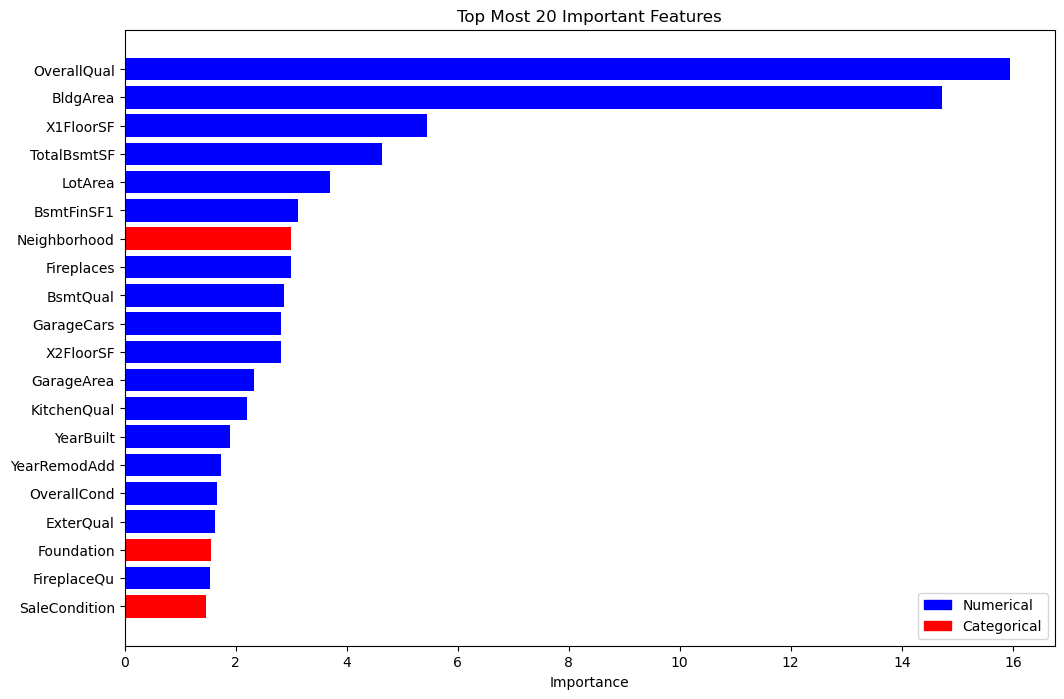

In [201]:
# Create a bar chart
plt.figure(figsize=(12, 8))

colors = {'Categorical': 'red', 'Numerical': 'blue'}
labels = ['Numerical', 'Categorical']
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

plt.barh(feature_importance_20['feature'], feature_importance_20['importance'], color=feature_importance_20['dtype'].map({'object': 'red', 'int64': 'blue', 'float64': 'blue'}))
plt.legend(['Numerical', 'Categorical'])
plt.xlabel('Importance')
plt.title('Top Most 20 Important Features')
plt.legend(handles, labels, loc = 'lower right')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

We observe that in this model the four most important variables are still the same as in the previous models, `BldgArea`, `OverallQual` & `TotalBsmtSF`. Moreover, three of the categorical variables appear in the 20 top ranking, `Neighborhood`, `Foundation` and `Sale Condition`. This is important to note because in the previous models, **none** of the categorical (encoded) variables appeared in the top 20 ranking, which shows that OHE is not the best technique for handling categorical variables in this case and highlights the powerful ability of catboost to handle categorical data.

# 5. Models Comparison
After tuning, aplying and testing the different models during this project, we offer a comparison of the obtained results.

### 5.1. Metrics & Graphic Comparison
We will first compare the four models by means of the obtaiend metrics on the test set. For the first milestone, we will choose ElasticNET for the coparison, given that this regularized model gave significantly better results than the simple linear regression. Below, we present a table with the results of the three analyzed metrics for the three different models and the Real vs.Predicted price for each case:

| Metric | ElasticNET | Random Forest | CatBoost | 
|--------|------------|---------------|----------|
| RMSLE | 0.16 | 0.13 | 0.11 |
| R2 | 0.76 | 0.89 | 0.94 |
| RMSE | 43809.96 | 29936.08 | 19691.46 |
| Graphic | ![ElasticNet](ENET_graph.png) | ![Random Forest](RF_graph.png) | ![CatBoost](CB_graph3.png) |


The metrics show that both the Random Forest and CatBoost algorithm had a good (and similar) performance on test data. Moreover, the graphs show that in both cases this algorithms performed better on low and medium property values, presenting a bigger dispersion on the higher values. This shows that probably some kind of treatment on top extreme values would have a good impact on model's performance.

### 5.2. Feature Importance Comparison
To go a step beyonf and understand the most influential variables on each model, we present below a table comparing the top 5 most important variables for ElasticNET, Random Forest and CatBoost algorithms:

| Variable Importance | ElasticNET | Random Forest | CatBoost | 
|---------------------------|------------|---------------|----------|
| 1° | OverallQual | OverallQual | OverallQual |
| 2° | BldgArea | BldgArea | BldgArea |
| 3° | TotalBsmntSF | X1FloorSF | X1FloorSF |
| 4° | X1FloorSF | GarageCars | TotalBsmntSF |
| 5° | MasVnrArea | TotalBsmtSF | LotArea |

From this comparative table, we can observe that 4 of the 5 most important features are shared by the three models, occupying the first two places Overall Quality and BldgArea. Moreover, we observe that, in all cases, the variables related to surface area are the ones that have a biggest impact on model, apart from overall quality.

## 6. Conclusion

### 6.1. Advising a business entity
If we were to advise a company on the implementation of one of the models, we would suggest the application of the CatBoost model without hyperparameter tuning. This decision is due to the fact that the CatBoost model, without applying any tuning, showed a high (RMSLE = 0.11) performance with almost no difference to the optimised model. While the final Random Forest model performed reasonably well, its performance is still lower than that of CatBoost. Further, the tuning of hyperparameters in Random Forest also can be a time-consuming process. In addition, CatBoost has the advantage of saving preprocessing steps, mainly with respect to categorical variables, and other preprocessing functions, such as handling NA values according to criteria set by the user. In this sense, we consider that CatBoost offers a very good performance-to-complexity ratio that would be the most beneficial for deploying it.


### 6.2. Future work (proposed explorations for next 3 months)
For future work, we would like to explore the following aspects:

*The main experiment*: 
We would like to try obtaining the property location data from Ames website and appending it to our current data using the `PID` column. This would allow us to study and account for spatial autocorrelation of the sale prices and other variables in the data. This would be interesting because, the influence of location on the sale price of residential properties is well discussed in literature and we would like to refer this body of literature to inform our spatial analysis. Currently, while the `Neighborhood` column is a good proxy for location, it does not account for spatial autocorrelation - such as for quantifying the spatial pattern of house prices within the neighborhoods and among neighbourhoods themselves. Addition of location data and subsequent quantification of spatial autocorrelation would allow us to make the model more robust.

*Other experiments*:
- We observe that all our models perform better for low and medium range priced houses than high priced ones. It would be useful to perform a deep dive on analyzing properties in the high price range.
- For all the models we would like to implement nested cross-validation to obtain a more robust estimate of the generalization performance of the models.
- For Catboost model, we would like to explore the influence of other secondary parameters on the predictions and if tuning them can give better results.
- Finally, in the Catboost model, we would like to combine Bayesian optimisation along with cross-validation for hyperparameter tuning. In our current implementation, we have only one each of training, validation and testing datasets. Our hypothesis is that our tuning could benefit from cross-validation by allowing the optimisation process to converge faster while acheiving better estimate of empirical risk.

## Appendix

### I. Kruskal Wallis H-Test Results

| Variable       | Statistic  | P-value            |
|----------------|------------|--------------------|
| Neighborhood   | 868.532    | 6.697e-168         |
| GarageType     | 532.696    | 7.581e-112         |
| MSSubClass     | 531.536    | 1.897e-104         |
| Foundation     | 488.723    | 2.169e-103         |
| MasVnrType     | 281.871    | 8.800e-60          |
| MSZoning       | 270.070    | 3.081e-57          |
| Exterior1st    | 304.045    | 1.694e-56          |
| Exterior2nd    | 284.231    | 1.048e-51          |
| HouseStyle     | 185.429    | 1.389e-36          |
| SaleCondition  | 168.323    | 1.663e-34          |
| SaleType       | 156.383    | 9.120e-30          |
| Electrical     | 131.511    | 1.137e-26          |
| PavedDrive     | 115.839    | 7.012e-26          |
| BldgType       | 69.801     | 2.501e-14          |
| Condition1     | 74.404     | 6.493e-13          |
| LandContour    | 35.310     | 1.048e-07          |
| RoofStyle      | 39.878     | 1.581e-07          |
| LotConfig      | 35.724     | 3.298e-07          |
| Heating        | 33.267     | 3.331e-06          |
| RoofMatl       | 18.872     | 0.009              |
| Condition2     | 17.774     | 0.013              |

***Table***: *Test results for Kruskal-Wallis H-test for categorical variables w.r.t. Sale Price*

### II. Grid-Search Hyparparameter Tuning Test
We present here a Grid-Search based cross-validation hyperparameter tunning approach, which was the first technique we tried to implement during when doing the project. After playing around with this version, we later decided to not rely on it for two main reasons. Firstly, we found it to be computationally expensive and time consuming (run time >2 hours). Secondly, we could not find a simple way to implement RMSLE (our chosen main evaluation metric) as the loss function for Catboost's inbuilt `grid_search()` method. Implementation of RMSLE as custom loss function is much straighforward in Sci-Kit Learn's `GridSearchCV()`. And Catboost is not compatible with the latter. While Catboost supports the Mean Squared Logarithmic Error (MSLE) metric, it cannot be used for optimization [(Catboost, n.d.)](https://catboost.ai/en/docs/concepts/loss-functions-regression#usage-information). 

In this section we document our approach to Catboost hyperparameter tuning using Grid-Search but we do not recommend it. Instead, Optuna based Bayesian optimization is a much better approach for tuning Catboost hyperparameters which is discussed in this notebook.

In order to be able to perform grid search on training data, we should pass the model, the parameters and the cross validation object to the `grid_search()` method. For this, we create a cross validation object with 5 folds. This cannot be directly created using the instantiation of the StratifiedKFold object because such an object will only be useful in a classification problem. Where stratification is carried out on the target variable. Since we need to stratify based on an independent variable, `Neighborhood` , we need to create the splits accordingly and then convert them into a CV object which can be passed to GridSearchCV function. 

In [26]:
# create a stratified kfold object
kf = StratifiedKFold(n_splits=5, random_state=33, shuffle=True)

#we want each of the folds to have the same distribution of neighborhoods
splits = kf.split(data_train, data_train['Neighborhood'])
#print(splits)

# creating a nested list of train and validation indices for each fold
train_indices, val_indices = [list(trainval) for trainval in zip(*splits)]

# create a list of tuples containing the train and validation indices for each fold
# this is the format expected by the cv parameter during grid search algorithm

cv_object = [*zip(train_indices, val_indices)] 

In [27]:
%%time
# DO NOT RUN THIS CODE BLOCK. TIME> 2 HOURS
# list of categorical feature names
cat_names = list(data_train.drop('SoldPrice', axis=1).select_dtypes(include=['object']).columns)
print(cat_names)

# Create Pool
train_pool_whole= Pool(data_train.drop('SoldPrice', axis=1), 
                  label = data_train['SoldPrice'],
                  cat_features = cat_names)

#instantiate the model
cbr = CatBoostRegressor(random_seed=33)
#create the grid
grid = {'n_estimators':[200, 400,600,800,1000, 1200, 1400],
        'depth': [2,4,6,8],
        'l2_leaf_reg': [2,3,5],
        }

grid_search_result = cbr.grid_search(grid, train_pool_whole,cv=cv_object)

['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
0:	learn: 190402.7897267	test: 197540.9457114	best: 197540.9457114 (0)	total: 24ms	remaining: 4.78s
1:	learn: 185301.3424592	test: 192400.2084792	best: 192400.2084792 (1)	total: 36.7ms	remaining: 3.64s
2:	learn: 180254.3550505	test: 187275.2124684	best: 187275.2124684 (2)	total: 50.3ms	remaining: 3.31s
3:	learn: 175542.0823141	test: 182666.7152693	best: 182666.7152693 (3)	total: 67.8ms	remaining: 3.32s
4:	learn: 170926.4280662	test: 177962.1089225	best: 177962.1089225 (4)	total: 80.6ms	remaining: 3.14s
5:	learn: 166477.6681232	test: 173593.0659316	best: 173593.0659316 (5)	total: 98.8ms	remaining: 3.19s
6:	learn: 162080.2066236	test: 169291.5685682	best: 169291.5685682 (6)	total: 112ms	remaining: 3.09s
7:	learn: 15

In [47]:
print('CV results',grid_search_result['cv_results']['test-RMSE-mean'])
min_rmse = min(grid_search_result['cv_results']['test-RMSE-mean'])
print('Minimum RMSE', min_rmse)

CV results [191918.148865283, 187018.44285449077, 182207.38567162654, 177549.6985719141, 172948.1660358833, 168530.230602583, 164257.6911992267, 160090.74955435787, 156044.76912126425, 152090.74636240592, 148352.87149922113, 144731.74774666323, 141204.34348588294, 137774.51090817605, 134449.81554175075, 131196.5822874123, 128051.8856123721, 124998.24475058068, 121991.50041180845, 119058.72311413253, 116235.66526135286, 113521.91358692192, 110838.47335178049, 108167.84157777252, 105647.15086861684, 103254.82035820946, 100907.68962060174, 98646.08514169663, 96364.16805573332, 94312.88396447156, 92139.88059121647, 90139.75445608734, 88192.43713185769, 86325.72728596636, 84510.2931217711, 82746.05441400266, 80998.65961646795, 79331.7503965557, 77705.96780400851, 76164.33607665179, 74690.81173672581, 73190.58787425447, 71759.744561628, 70321.29901460352, 68919.03994882891, 67619.63709997991, 66327.74404784194, 65081.019273984515, 63949.47638390501, 62807.15267614465, 61660.08918528749, 6058

In [31]:
# best parameters (i.e. params at minimum RMSE) from the grid search
grid_search_result['params']

{'depth': 8, 'l2_leaf_reg': 5, 'iterations': 1400}

We now evaluate the test performance of the model trained on the tuned parameters.

In [45]:
model3 = catboost.CatBoostRegressor(depth= 8, l2_leaf_reg= 5, iterations= 1400, random_seed=33)
model3.fit(train_pool_whole, verbose=0)
y_pred = model3.predict(test_pool)

RMSLE:  0.10798553521304485
R2 Score:  0.9375692991802839
RMSE:  19681.166024890703


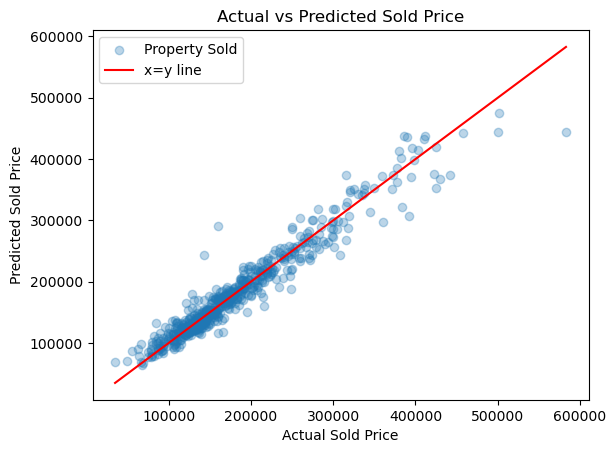

In [46]:
print('RMSLE: ', rmsle(data_test['SoldPrice'], y_pred))
print('R2 Score: ', model3.score(data_test.drop('SoldPrice', axis=1), data_test['SoldPrice']))
print('RMSE: ',rmse(data_test['SoldPrice'], y_pred))
plot_Yt_Yp(data_test['SoldPrice'].values, y_pred)

We can see that model trained with grid-search tuned hyperparameters gives an RMSLE and R2 score same as the one trained with Optuna tuned hyperparameters. However, the grid-search based model does slightly better in terms of RMSE which is 10 units less than the Optuna based model. Since this is marginal improvement for a much longer run time, we do not recommend using grid-search for tuning Catboost hyperparameters.

# References
1. Amazon Web Services, Inc. (2023). [*Tuning CatBoost Hyperparameters.*](https://docs.aws.amazon.com/sagemaker/latest/dg/catboost-tuning.html) *Amazon SageMaker Documentation*.

2. Atygayev, A. (2021). [*CatBoost Hyperparameter Tuning Guide with Optuna.*](https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/) *Forecastegy*.

3. CatBoost. (n.d.). [*CatBoost: Documentation.*](https://catboost.ai/)

4. CatBoost. (n.d.). [*CatBoost tutorial: Categorical features parameters.*](https://github.com/catboost/catboost/blob/master/catboost/tutorials/categorical_features/categorical_features_parameters.ipynb)

5. CatBoost. (n.d.). [*CatBoost tutorial: Hyperparameter tuning using Optuna and Hyperopt.*](https://github.com/catboost/catboost/blob/master/catboost/tutorials/hyperparameters_tuning/hyperparameters_tuning_using_optuna_and_hyperopt.ipynb)

6. Catboost. (n.d.). [*Regression: objectives and metrics*](https://catboost.ai/en/docs/concepts/loss-functions-regression#usage-information)

6. Cook, A. (2021). [*Cross-Validation.*](https://www.kaggle.com/alexisbcook/cross-validation) *Kaggle*.

7. DATATab. (2023). [*Kruskal-Wallis Test.*](https://datatab.net/tutorial/kruskal-wallis-test)

8. Dorogush, A. V., Ershov, V., & Gulin, A. (2018). [*CatBoost: A new benchmark in boosting algorithms.*](http://learningsys.org/nips17/assets/papers/paper_11.pdf) *Advances in Neural Information Processing Systems*.

9. Filho, A. (2023). [*CatBoost Hyperparameter Tuning Guide with Optuna.*](https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/) *Forecastegy*.

10. Gupta, A. (n.d.). [*CatBoost-in-Python-ML.*](https://github.com/anantgupta129/CatBoost-in-Python-ML/tree/master)

11. Ledesma, C. (2021). [*Spatial Cross-Validation Using scikit-learn.*](https://towardsdatascience.com/spatial-cross-validation-using-scikit-learn-74cb8ffe0ab9) *Medium*.

12. Prokhorenkova, L., Gusev, G., Vorobev, A., Dorogush, A. V., & Gulin, A. (2018). [*CatBoost: unbiased boosting with categorical features.*](https://arxiv.org/pdf/1706.09516.pdf) *arXiv preprint arXiv:1706.09516*.

13. Saini, N. (2019). [*What is Stratified Cross-Validation in Machine Learning?*](https://towardsdatascience.com/what-is-stratified-cross-validation-in-machine-learning-8844f3e7ae8e) *Towards Data Science*.

14. Scikit-Learn. (n.d.). [*Plot Nested Cross-Validation for Iris Dataset.*](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)